In [1]:
# move workidir to the correct folder
import os
os.chdir("../")


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

# Custom Libs
from dataset.dataset import Dataset
import matplotlib.pyplot as plt

In [16]:
# Set up which conlumn to use as a target :
# 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
# 'review_scores_communication', 'review_scores_location', 'review_scores_value',

REFERENCE_COlUMN = "review_scores_rating"
BUCKETS = [(0, 4), (4, 4.5), (4.5, 4.8), (4.8, 5)]
OUTLIERS_HIGH = 4.99999
OUTLIERS_LOW = 0


# Other experiments
# REFERENCE_COlUMN = "price"
# BUCKETS = [(50,100), (100, 200), (200, 300), (300,400), (400,500)]
# OUTLIERS_HIGH = 500
# OUTLIERS_LOW = 50

# REFERENCE_COlUMN = "price"
# BUCKETS = [(50, 100), (100, 150), (150, 200)]
# OUTLIERS_LOW = 50
# OUTLIERS_HIGH = 200


In [17]:
# Load the precleaned and spearated datset
with open(f'./dataset/train_dataset.pkl', 'rb') as f:
    train_dataset = pd.read_pickle(f)

with open(f'./dataset/test_dataset.pkl', 'rb') as f:
    test_dataset = pd.read_pickle(f)

In [18]:
y_train = train_dataset.getAllScores()[REFERENCE_COlUMN]
X_train = train_dataset.getComments()

In [19]:
# Load and prepare Test
y_test = test_dataset.getAllScores()[REFERENCE_COlUMN]
X_test = test_dataset.getComments()

In [20]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Drop nan values based on target conlumn
empty_target_indexes_train = y_train.notna()
X_train = X_train[empty_target_indexes_train]
y_train = y_train[empty_target_indexes_train]

empty_target_indexes_test = y_test.notna()
X_test = X_test[empty_target_indexes_test]
y_test = y_test[empty_target_indexes_test]

## Appling cutout
not_outliers_idx = y_train <= OUTLIERS_HIGH
not_outliers_idx_2 = y_train[y_train <= OUTLIERS_HIGH] >= OUTLIERS_LOW
X_train = X_train[not_outliers_idx][not_outliers_idx_2]
y_train = y_train[not_outliers_idx][not_outliers_idx_2]

not_outliers_idx = y_test <= OUTLIERS_HIGH
not_outliers_idx_2 = y_test[y_test <= OUTLIERS_HIGH] >= OUTLIERS_LOW
X_test = X_test[not_outliers_idx][not_outliers_idx_2]
y_test = y_test[not_outliers_idx][not_outliers_idx_2]


In [30]:
y_test.describe()

count    1330.000000
mean      197.878189
std        93.567444
min        50.000000
25%       128.000000
50%       179.000000
75%       249.000000
max       500.000000
Name: price, dtype: float64

In [21]:
# Bucket generations
def bucketizie(x):
    for i in range(len(BUCKETS)):
        start, end = BUCKETS[i]
        if (i == 0): 
            if x >= start and  x<=end: return i
        else:
            if x > start and  x<=end: return i
        
    return len(BUCKETS) -1

y_train_buckets = [bucketizie(val) for val in y_train]
y_test_buckets = [bucketizie(val) for val in y_test]


In [22]:
print(np.unique(y_train_buckets))

array([0, 1, 2, 3, 4])

In [23]:
# An util function to plot the result of a trained model on the test data
from sklearn import metrics
from lightgbm import LGBMClassifier


def evaluate_and_display(model, x, y):
    y_hat = model.predict(x).round()

    # print reference
    for i in range(len(BUCKETS)):
        start, end = BUCKETS[i]
        print(f"Bucket {i}-> {start}-{end}")
 
    ## Confusion
    cm = metrics.confusion_matrix(y, y_hat)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    ## ROC
    fpr, tpr, thresholds = metrics.roc_curve(y, y_hat, pos_label=2)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print("AUC:", auc)

    # Accuracy
    print("Accuracy:", metrics.accuracy_score(y, y_hat))

    print(metrics.classification_report(y, y_hat))

## LGBMClassifier

Bucket 0-> 50-100
Bucket 1-> 100-200
Bucket 2-> 200-300
Bucket 3-> 300-400
Bucket 4-> 400-500


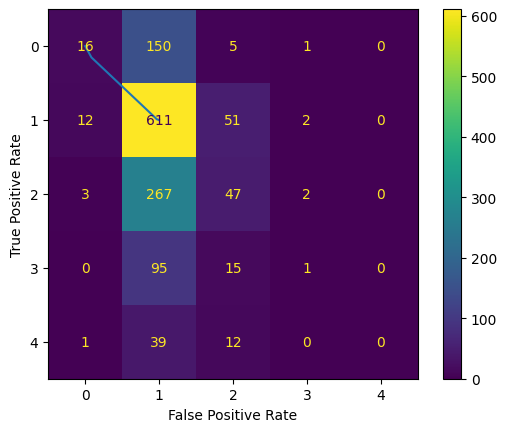

AUC: 0.5415833356588499
Accuracy: 0.5075187969924813
              precision    recall  f1-score   support

           0       0.50      0.09      0.16       172
           1       0.53      0.90      0.66       676
           2       0.36      0.15      0.21       319
           3       0.17      0.01      0.02       111
           4       0.00      0.00      0.00        52

    accuracy                           0.51      1330
   macro avg       0.31      0.23      0.21      1330
weighted avg       0.43      0.51      0.41      1330



/home/mangelini/miniconda3/envs/NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mangelini/miniconda3/envs/NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mangelini/miniconda3/envs/NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [24]:
# train model
import lightgbm as lgb
# impor model
model = lgb.LGBMClassifier()
# fit model
model.fit(X_train, y_train_buckets)


evaluate_and_display(model, X_test, y_test_buckets)

## Random forest

Bucket 0-> 50-100
Bucket 1-> 100-200
Bucket 2-> 200-300
Bucket 3-> 300-400
Bucket 4-> 400-500


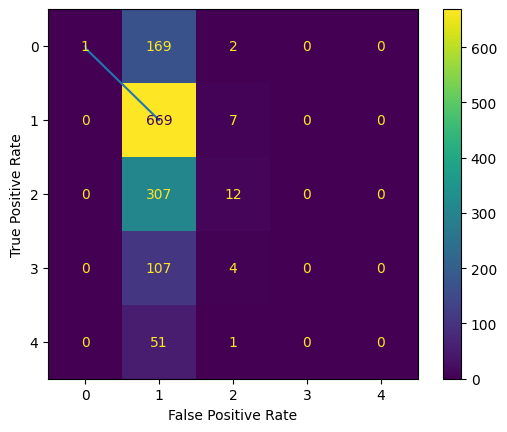

AUC: 0.5123608953548584
Accuracy: 0.512781954887218
              precision    recall  f1-score   support

           0       1.00      0.01      0.01       172
           1       0.51      0.99      0.68       676
           2       0.46      0.04      0.07       319
           3       0.00      0.00      0.00       111
           4       0.00      0.00      0.00        52

    accuracy                           0.51      1330
   macro avg       0.39      0.21      0.15      1330
weighted avg       0.50      0.51      0.36      1330



/home/mangelini/miniconda3/envs/NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mangelini/miniconda3/envs/NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mangelini/miniconda3/envs/NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [25]:
from sklearn.ensemble import RandomForestClassifier

# import model
model = RandomForestClassifier()

# fit model
model.fit(X_train, y_train_buckets)

evaluate_and_display(model, X_test, y_test_buckets)


## SVM one vs all

Bucket 0-> 50-100
Bucket 1-> 100-200
Bucket 2-> 200-300
Bucket 3-> 300-400
Bucket 4-> 400-500


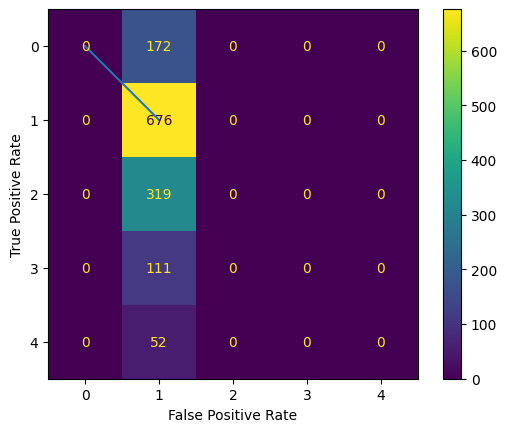

AUC: 0.5
Accuracy: 0.5082706766917293
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       172
           1       0.51      1.00      0.67       676
           2       0.00      0.00      0.00       319
           3       0.00      0.00      0.00       111
           4       0.00      0.00      0.00        52

    accuracy                           0.51      1330
   macro avg       0.10      0.20      0.13      1330
weighted avg       0.26      0.51      0.34      1330



/home/mangelini/miniconda3/envs/NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mangelini/miniconda3/envs/NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mangelini/miniconda3/envs/NLP/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [26]:
from sklearn.svm import SVC

# import model
model = SVC(gamma='auto', kernel= "rbf")

# fit model
model.fit(X_train, y_train_buckets)


evaluate_and_display(model, X_test, y_test_buckets)


## apply the mlp classifier to predict the correct bin


In [27]:
# from model.models.classifier import MLPClassifier

# # convert to tensor and float
# X_train = torch.tensor(X_train).float()
# X_test = torch.tensor(X_test).float()
# y_train = torch.tensor(y_train)
# y_test = torch.tensor(y_test)

# # impor model
# input_dim = X_train.shape[1]
# output_dim = len(np.unique(y_train))
# hidden_dim = 100

# model = MLPClassifier(input_dim, hidden_dim, output_dim)

# # fit model
# model.fit(X_train, y_train)

# # predict
# y_pred = model.predict(X_test)

# # evaluate


In [28]:
y_train

1032     91.0
4490    205.0
6885    400.0
1721    500.0
1919    100.0
        ...  
3772    135.0
5191     87.0
5226    180.0
5390    150.0
860     246.0
Name: price, Length: 5335, dtype: float32

In [29]:
# Create equal probability bins at the PENTILES of RATING
# labels below_4.3, 4.3_to_4.8, 4.8_to_5
labels = [0,1,2]


listings['review_scores_rating'] = pd.qcut(
        listings['review_scores_rating'],
        q=3,
        duplicates='drop',
        labels=labels
    )

# Visualize the Split
sns.countplot(listings['review_scores_rating'])

# add plot title and axis labels
plt.title('Distribution of Review Scores')
plt.xlabel('Review Scores')
plt.ylabel('Number of Listings')

# display the plot
plt.show()



NameError: name 'listings' is not defined

In [ ]:
# discretize review_scores_rating
listings['review_scores_rating'] = pd.cut(listings['review_scores_rating'], bins=5,
                                         labels=['0.0-1.0', '1.0-2.0', '2.0-3.0', '3.0-4.0', '4.0-5.0'])

# replace null values in description and review_scores_rating
listings['description'].replace(np.NaN, 'no_description', inplace=True)
listings['review_scores_rating'].replace(np.NaN, 'no_review', inplace=True)

In [ ]:
listings.review_scores_rating.head()

0    4.0-5.0
1    4.0-5.0
2    4.0-5.0
3    4.0-5.0
4    4.0-5.0
Name: review_scores_rating, dtype: category
Categories (5, object): ['0.0-1.0' < '1.0-2.0' < '2.0-3.0' < '3.0-4.0' < '4.0-5.0']

In [ ]:
listings.review_scores_rating.value_counts()

4.0-5.0    6037
3.0-4.0     110
2.0-3.0       6
0.0-1.0       4
1.0-2.0       4
Name: review_scores_rating, dtype: int64

In [ ]:
from nltk.corpus import stopwords
import nltk


# Snipped to execute the download of nltk moule only if not present
nltk.download("stopwords")
nltk.download('punkt')

ENGLISH_STOP_WORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kyriakos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kyriakos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
!python -m spacy download en_core_web_sm

2023-04-21 16:39:55.542120: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2023-04-21 16:39:55.542506: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-21 16:39:58.361629: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library nvcuda.dll
2023-04-21 16:39:58.362074: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:25:00.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.4425GHz coreCount: 6 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 104.43GiB/s
2023-04-21 16:39:58.364664: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2023-04-21 16:39:58.366871: W tensorflow/stream_execu


     ---------------------------------------- 12.8/12.8 MB 4.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# import libraries for handling text
import scattertext as st
import spacy

from pprint import pprint

from sentence_transformers import SentenceTransformer
# nlp = SentenceTransformer('distiluse-base-multilingual-cased-v2')
# load SBERT
nlp = spacy.load("en_core_web_sm")

# create a scattertext corpus & look for differences between listing descriptions in ratings
# remove stop words
corpus = (st.CorpusFromPandas(listings,
                              category_col='review_scores_rating',
                              text_col='description',
                              nlp=nlp)
          .build()
          .remove_terms(ENGLISH_STOP_WORDS, ignore_absences=True))

# generate scatterplot and save to HTML file
# set a minimum term frequency to filter out infrequent words
html = st.produce_scattertext_explorer(corpus,
          category='4.0-5.0',
          category_name='Star Rating 4.0 - 5.0',
          not_category_name='All Other Ratings',
          width_in_pixels=1000,
          minimum_term_frequency=200)
open('term-associations.html', 'wb').write(html.encode('utf-8'))

5510361

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read in the data from the HTML file
df = pd.read_html('term-associations.html')[0]
# df = pd.read_html('term-associations.html', flavor='html5lib')[0]


# Create a scatterplot using Matplotlib
plt.scatter(df['x'], df['y'])

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatterplot')

# Show the plot
plt.show()


ImportError: lxml not found, please install it